Aquí proporcionamos una breve descripción de cada función.

- **encounter ID**  Identificador único de un encuentro
- **patient number** Identificador único de un paciente
- **Race** valores de caucásico, asiático, afroamericano, hispano y otros
- **gender**  masculino, femenino y desconocido/no válido
- **age** Agrupada en intervalos de 10 años: 0, 10), 10, 20),…, 90, 100)
- **weight** Peso en libras
- **admission type** Identificador entero correspondiente a 9 valores distintos, por ejemplo, emergencia, urgente, electiva, recién nacido y no disponible
- **discharge disposition** Identificador entero correspondiente a 29 valores distintos, por ejemplo, descargada a domicilio, caducada y no disponible
- **admission source** Identificador entero correspondiente a 21 valores distintos, por ejemplo, referencia médica, sala de emergencias y traslado desde un hospital
- **time in hospital** Número entero de días entre el ingreso y el alta
- **payer code** Identificador entero correspondiente a 23 valores distintos, por ejemplo, Blue Cross/Blue Shield, Medicare y pago médico por cuenta propia
- **medical specialty** Identificador entero de una especialidad del médico de admisión, correspondiente a 84 valores distintos, por ejemplo, cardiología, medicina interna, medicina familiar/general y cirujano
- **number of lab procedures**  Número de pruebas de laboratorio realizadas durante el encuentro
- **number of procedure** Numérico Número de procedimientos (que no sean pruebas de laboratorio) realizados durante el encuentro
- **number of medications** Número de nombres genéricos distintos administrados durante el encuentro
- **number of outpatient visits** Número de visitas ambulatorias del paciente en el año anterior al encuentro
- **number of emergency visits** Número de visitas de emergencia del paciente en el año anterior al encuentro
- **number of inpatient visits** Número de visitas de pacientes hospitalizados del paciente en el año anterior al encuentro
- **diagnosis 1** El diagnóstico principal (codificado como los primeros tres dígitos de ICD9); 848 valores distintos
- **diagnosis 2** Diagnóstico secundario (codificado como los primeros tres dígitos de ICD9); 923 valores distintos
- **diagnosis 3** Diagnóstico secundario adicional (codificado como los primeros tres dígitos de ICD9); 954 valores distintos
- **number of diagnoses** Número de diagnósticos ingresados al sistema 0%
- **glucose serum test result** Indica el rango del resultado o si no se realizó la prueba. Valores: ">200", ">300", "normal" y "ninguno" si no se mide
- **A1c test result** Indica el rango del resultado o si no se realizó la prueba. Valores: “>8” si el resultado fue mayor al 8%, “>7” si el resultado fue mayor al 7% pero menor al 8%, “normal” si el resultado fue menor al 7% y “ninguno” si no medido
- **change of medications** Indica si hubo cambio de medicamentos para diabéticos (ya sea de dosis o de nombre genérico). Valores: “cambio” y “sin cambio”
Medicamentos para la diabetes Indica si se prescribió algún medicamento para la diabetes. Valores: “sí” y “no”
24 tipos diferentes de medicamentos.
- **readmitted** Días hasta la readmisión de pacientes hospitalizados. Valores: “❤0” si el paciente reingresó en menos de 30 días, “>30” si el paciente reingresó en más de 30 días y “No” si no hay registro de reingreso

In [2]:
# Importar  librerias  necesarias para el analisis de readmision hospitalaria de pacientes en condición clínica de diabetes
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly 
import plotly.express as px
#import scipy 
import warnings
warnings.filterwarnings("ignore")





In [3]:
# cargue de  data set desde  raiz del proyecto formato csv
df = pd.read_csv('./data/diabetic_data.csv', na_values='?', low_memory=False)
IDs_mapping= pd.read_csv('./data/IDs_mapping.csv', na_values='?', low_memory=False)

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [19]:
# Encontrar la posición de la fila que contiene registros NaN
posicion = np.where(IDs_mapping.isna().all(axis=1))
# se divide el dataset de mapping en 3, con el objetivo de identificar los merge completos 

admission_type_id = IDs_mapping.iloc[:posicion[0][0], : ]
discharge_disposition_id = IDs_mapping.iloc[posicion[0][0]+2:posicion[0][1], : ]
discharge_disposition_id.columns = ['discharge_disposition_id',	'description']
admission_source_id = IDs_mapping.iloc[posicion[0][1]+2:, : ]
admission_source_id.columns = ['admission_source_id','description']


In [29]:
# chequeo base  para  de cantidad de registros  que se tiene en el dataset
print(f'Cantidad de registros : {df.shape[0]} \nCantidad de columnas :{df.shape[1]}' )
print(f'Datos duplicados? : {df.duplicated().any()}')

Cantidad de registros : 101766 
Cantidad de columnas :50
Datos duplicados? : False


Incluso no hay duplicados, los registros representan encuentros individuales, por lo que puede haber más encuentros para un solo paciente. Comprobemos el número de encuentros y el número de pacientes:

In [30]:
print (f'Cantidad de encuentros con el paciente : {len(df.encounter_id.unique())} \nCantidad de pacientes atendidos en el counter: {len(df.patient_nbr.unique())}')

Cantidad de encuentros con el paciente : 101766 
Cantidad de pacientes atendidos en el counter: 71518


In [31]:
### descriptivas fundamentales por cada una de las  variables numericas
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [32]:
## frecuencia  y cantidad de valores unicos en cada  variable categorica 
df.describe(exclude=[np.number])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,17,72,716,748,789,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,32439,14635,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


Desde este punto de vista, podemos ver que algunos de los atributos parecen numéricos, pero también contienen cadenas (como None). Tendremos que comprobar eso mejor y analizarlos individualmente, porque esos atributos pueden representar por ejemplo algunos códigos o simplemente los resultados de algunas medidas.

In [33]:
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    #total = float(len(df))
    g = sns.countplot(x = df[feature], order = df[feature].value_counts().index, palette='Set3')
    g.set_title("Resultado por cada categoria de {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height),
                ha="center") 
    plt.show()


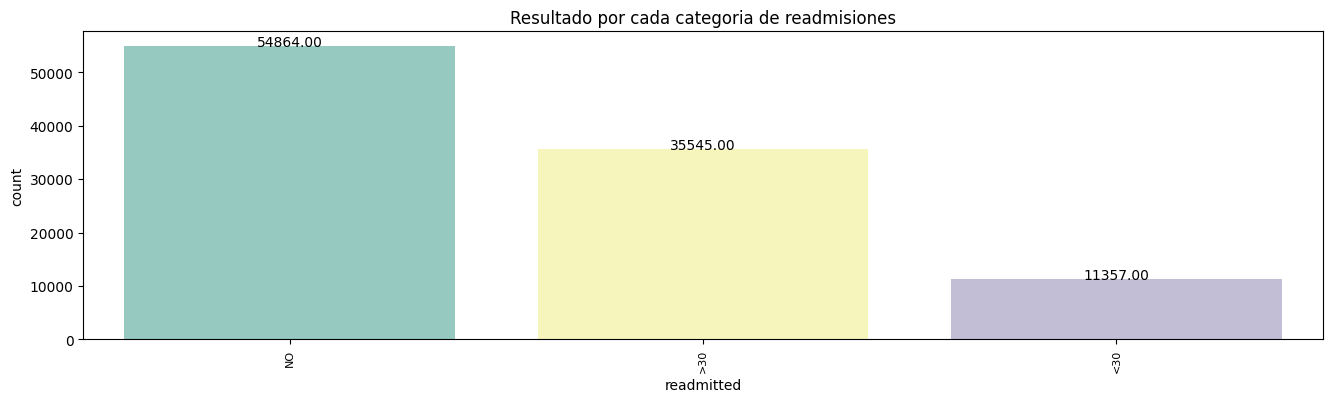

In [34]:
name = df.readmitted.value_counts().index
num  = df.readmitted.value_counts().values

fig = px.pie(data_frame=df,names=name,values=num
             ,title='Grafico de  pie sobre  los resultados de readmisión',width=800,height=600)
fig.update_traces(textposition='inside',textinfo='label+percent')
fig.show()

plot_count('readmitted', 'readmisiones', df, size=4)

In [36]:
def check_label(text):
    if text == '>30' or text =='<30':
        return 'Si'
    else:
        return 'No'
    
df['label'] =df['readmitted'].apply(check_label) 
df.label.value_counts()

No    54864
Si    46902
Name: label, dtype: int64

In [37]:
t = PrettyTable(['Nombre columna', 'cant. valores perdidos', '% valores perdidos'])
for column in df.columns:
    missing_count = len(df[column][df[column].isna()])
    missing_percentage = round(missing_count / len(df) * 100, 2)
    if missing_count > 0:
        #print(f'{column}: {missing_count} ({missing_percentage}%)')
        t.add_row([column,missing_count,f'{missing_percentage}%'])
print(t)    

+-------------------+------------------------+--------------------+
|   Nombre columna  | cant. valores perdidos | % valores perdidos |
+-------------------+------------------------+--------------------+
|        race       |          2273          |       2.23%        |
|       weight      |         98569          |       96.86%       |
|     payer_code    |         40256          |       39.56%       |
| medical_specialty |         49949          |       49.08%       |
|       diag_1      |           21           |       0.02%        |
|       diag_2      |          358           |       0.35%        |
|       diag_3      |          1423          |        1.4%        |
+-------------------+------------------------+--------------------+


In [38]:
def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=None, ax=None):
    """
    Grafica el Barplot de atributos para cada clase categorica
    
    :param df: dataframe  con la data que  sera graficada en el barplot.
    :param attribute: nombre del atributo a ser graficado en el barplot.
    :param groupby: nombre del atributo con la clase predictora.
    :param title: titulo del grafico.
    :param ticks_rotation:  rotacion sobre  x-ticks (etiquetas).
    :param topn: top n de clases a ser graficadas en el barplot.
    :param ax: objetos de eje de matplotlib considerado para la grafica.
    """
    uniq_values = df[attribute].value_counts().head(topn).index
    df = df[df[attribute].isin(uniq_values)]
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('porcentaje').mul(100).reset_index()
    sns.barplot(data = data , x = attribute, y ='porcentaje', hue=groupby,ax=ax)
    plt.xticks(rotation=ticks_rotation)
    plt.title(title)




def kdeplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Grafica el kdeplot de atributos para cada clase.
    
    :param df: dataframe  con la data que  sera graficada en el kdeplot.
    :param attribute: nombre del atributo a ser graficado en el kdeplot.
    :param groupby: nombre del atributo con la clase predictora.
    :param title: titulo del grafico.
    :param ticks_rotation:  rotacion sobre  x-ticks (etiquetas).
    :param ax: objetos de eje de matplotlib considerado para la grafica.
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)
    plt.legend()


def boxplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Grafica el boxplot de atributos para cada clase.
    
    :param df: dataframe  con la data que  sera graficada en el boxplot.
    :param attribute: nombre del atributo a ser graficado en el boxplot.
    :param groupby: nombre del atributo con la clase predictora.
    :param title: titulo del grafico.
    :param ticks_rotation:  rotacion sobre  x-ticks (etiquetas).
    :param ax: objetos de eje de matplotlib considerado para la grafica.
    """
    sns.boxplot(x=groupby, y=attribute, data=df, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64


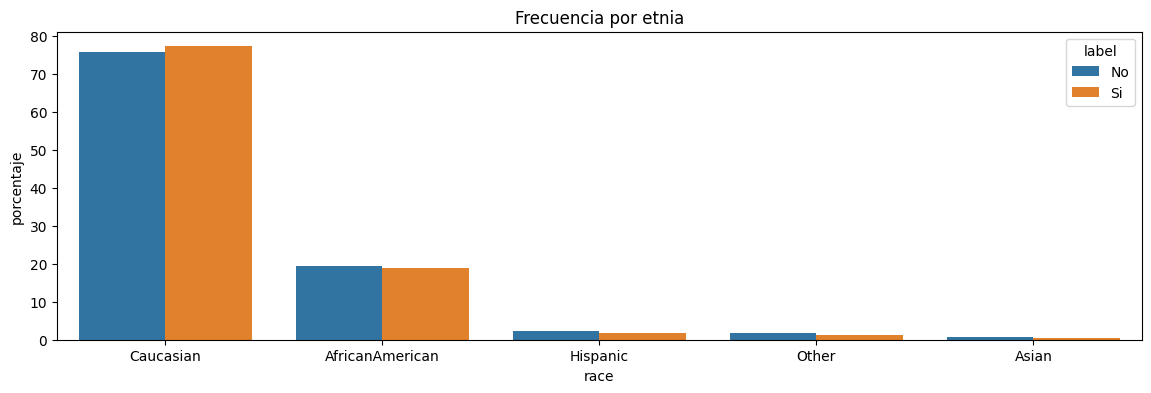

In [39]:
print(df.race.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'race', 'label', 'Frecuencia por etnia')


Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64


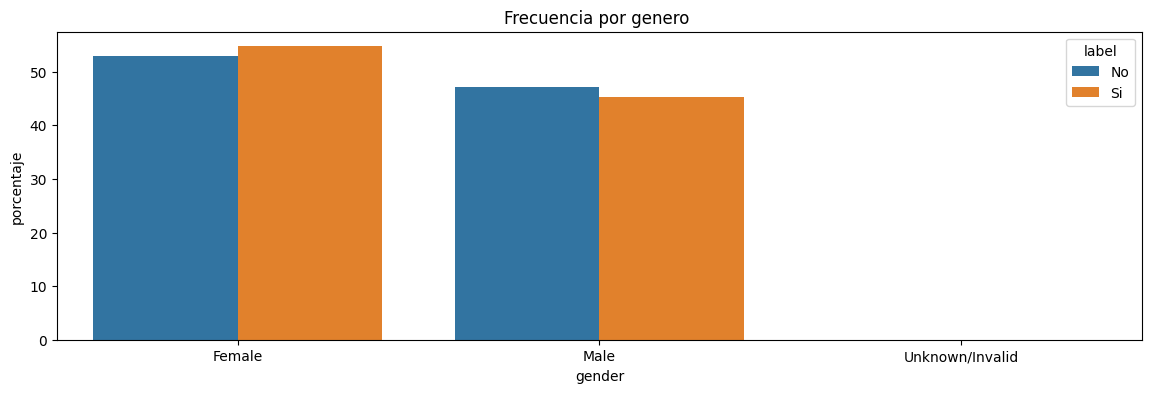

In [40]:
print(df.gender.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'gender', 'label', 'Frecuencia por genero ')

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64


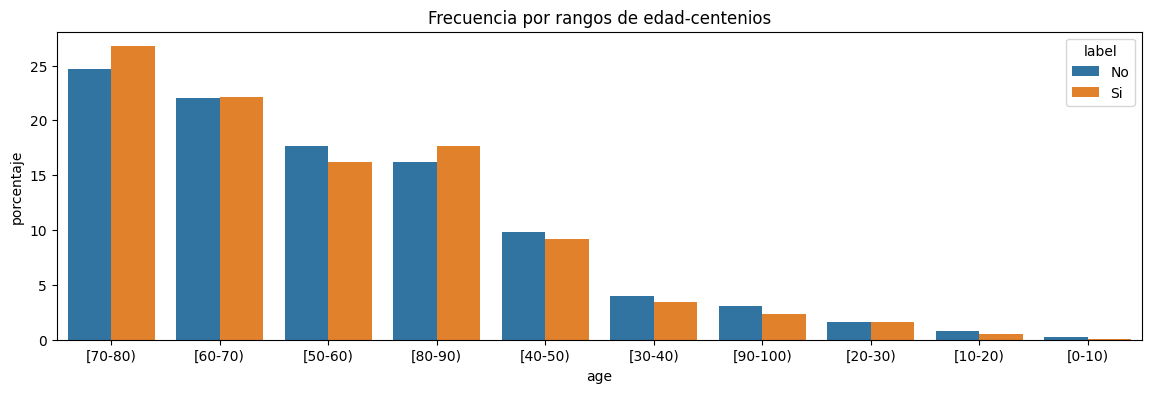

In [41]:
print(df.age.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'age', 'label', 'Frecuencia por rangos de edad-centenios')

In [42]:
def convert_age(age):
    """
    Convert age from interval into middle value.
    
    :param age: age interval.
    :return: middle value of age interval.
    """
    age = age[1:-1]
    lower_boundary = int(age.split('-')[0])
    upper_boundary = int(age.split('-')[1])
    return (upper_boundary + lower_boundary) / 2

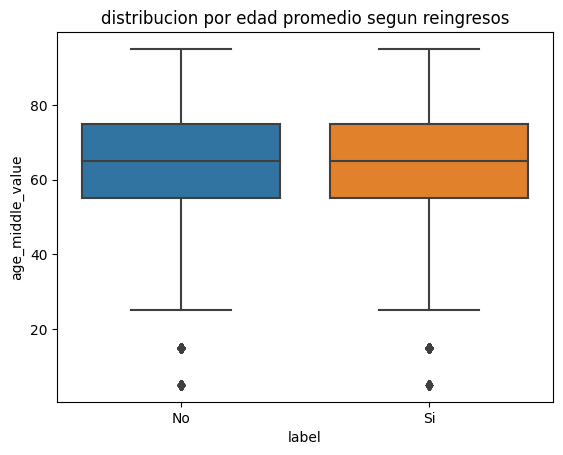

In [43]:
df['age_middle_value'] = df['age'].apply(lambda x: convert_age(x))
boxplot_per_classes(df, 'age_middle_value', 'label' , 'distribucion por edad promedio segun reingresos')

1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64


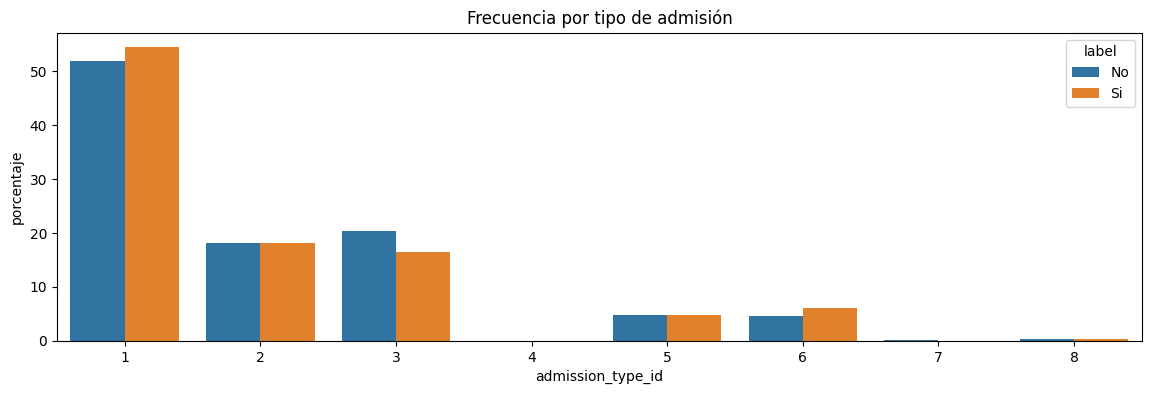

In [44]:
print(df.admission_type_id.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'admission_type_id', 'label', 'Frecuencia por tipo de admisión')

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64


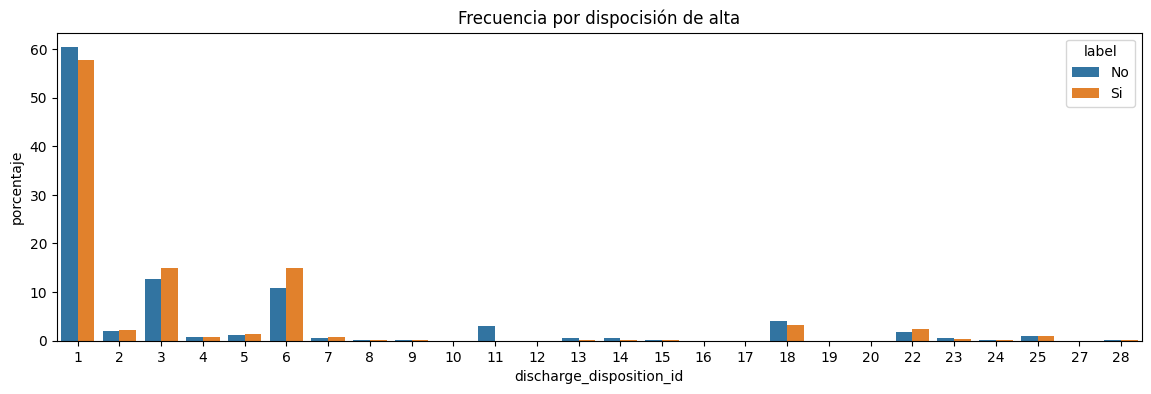

In [45]:

print(df.discharge_disposition_id.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'discharge_disposition_id', 'label', 'Frecuencia por dispocisión de alta')

7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
14        2
11        2
25        2
13        1
Name: admission_source_id, dtype: int64


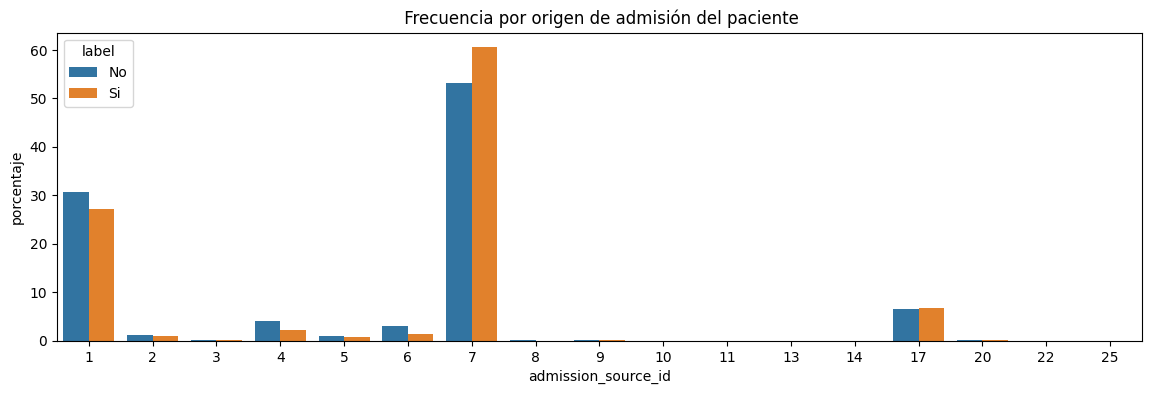

In [46]:
print(df.admission_source_id.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))

barplot_per_classes(df, 'admission_source_id', 'label', ' Frecuencia por origen de admisión del paciente')

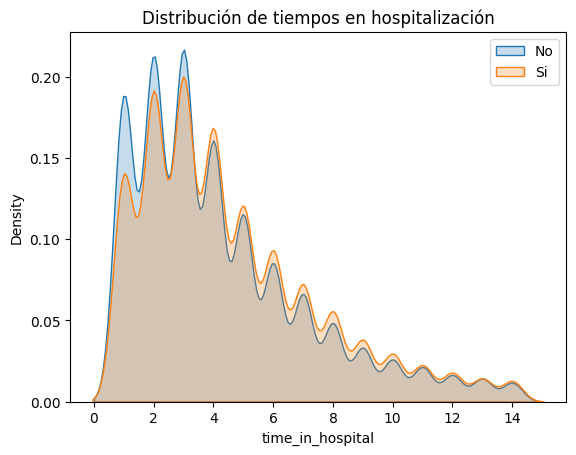

In [47]:
kdeplot_per_classes(df, 'time_in_hospital', 'label', 'Distribución de tiempos en hospitalización')


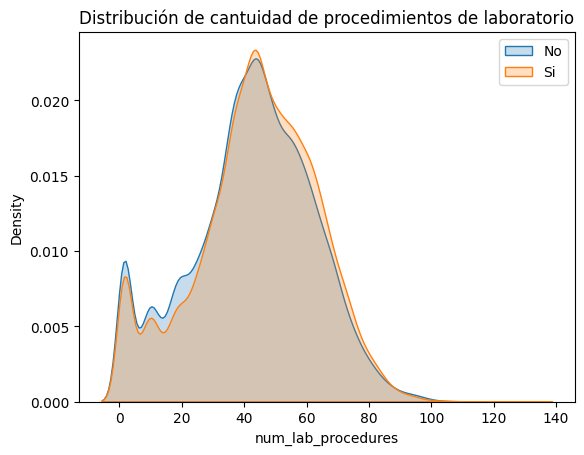

In [48]:

kdeplot_per_classes(df, 'num_lab_procedures', 'label', 'Distribución de cantuidad de procedimientos de laboratorio')

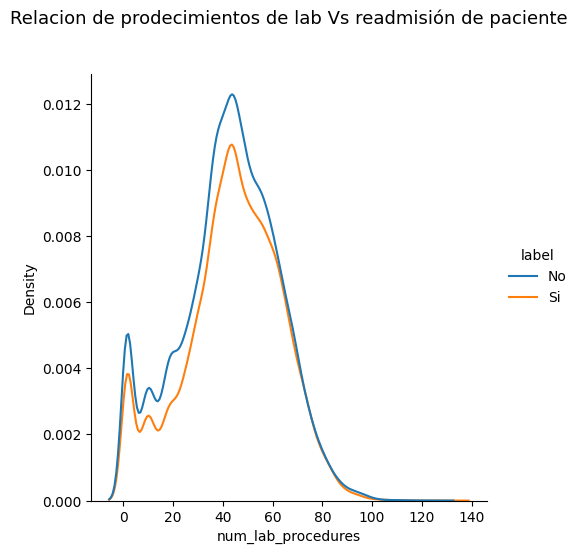

In [50]:
sns.displot(df, x="num_lab_procedures", hue= 'label', kind="kde")
plt.title('Relacion de prodecimientos de lab Vs readmisión de paciente\n\n', size = 13)
plt.show()

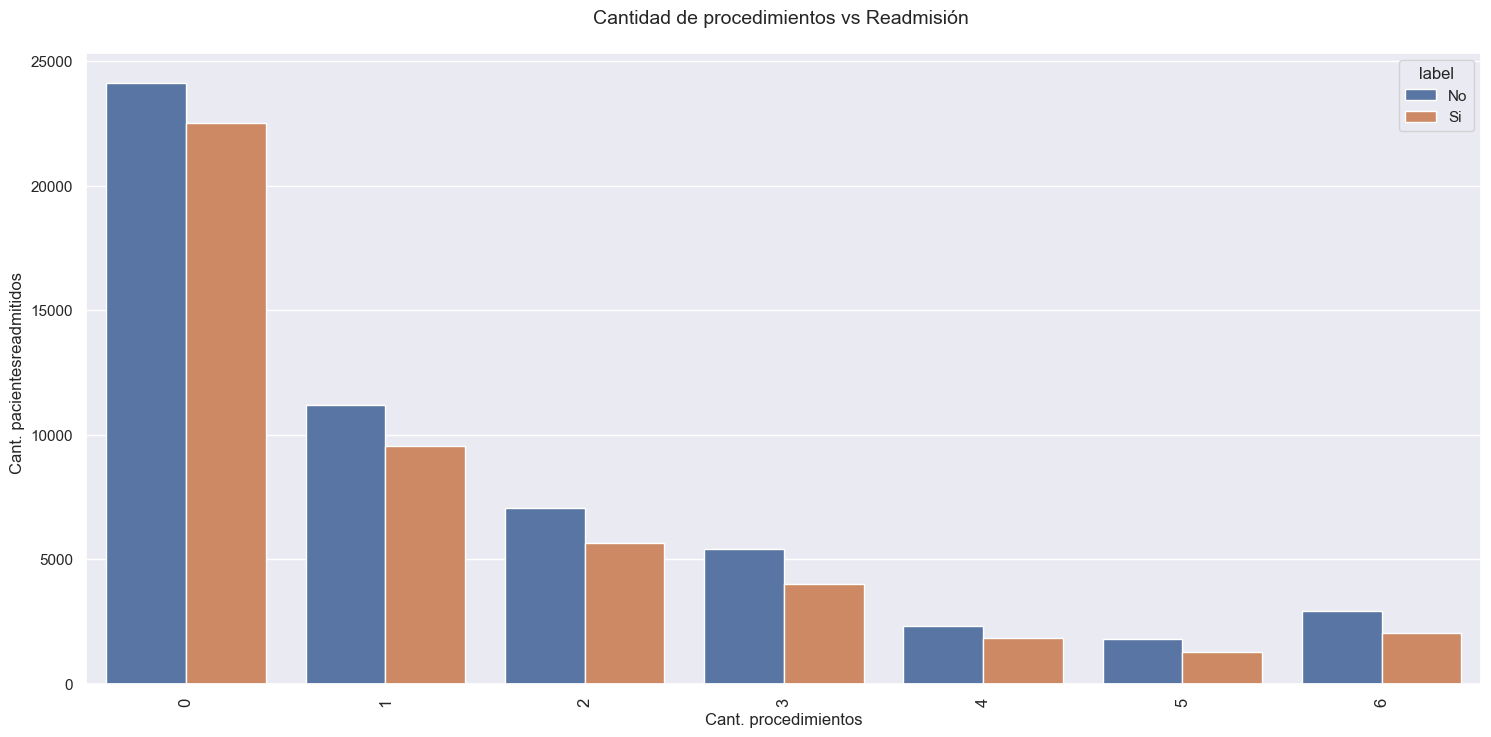

In [51]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='num_procedures',  hue= 'label',  data= df)
plt.xlabel('Cant. procedimientos', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Cant. pacientesreadmitidos  ', size = 12)
plt.title('Cantidad de procedimientos vs Readmisión \n', size = 14)
plt.show()

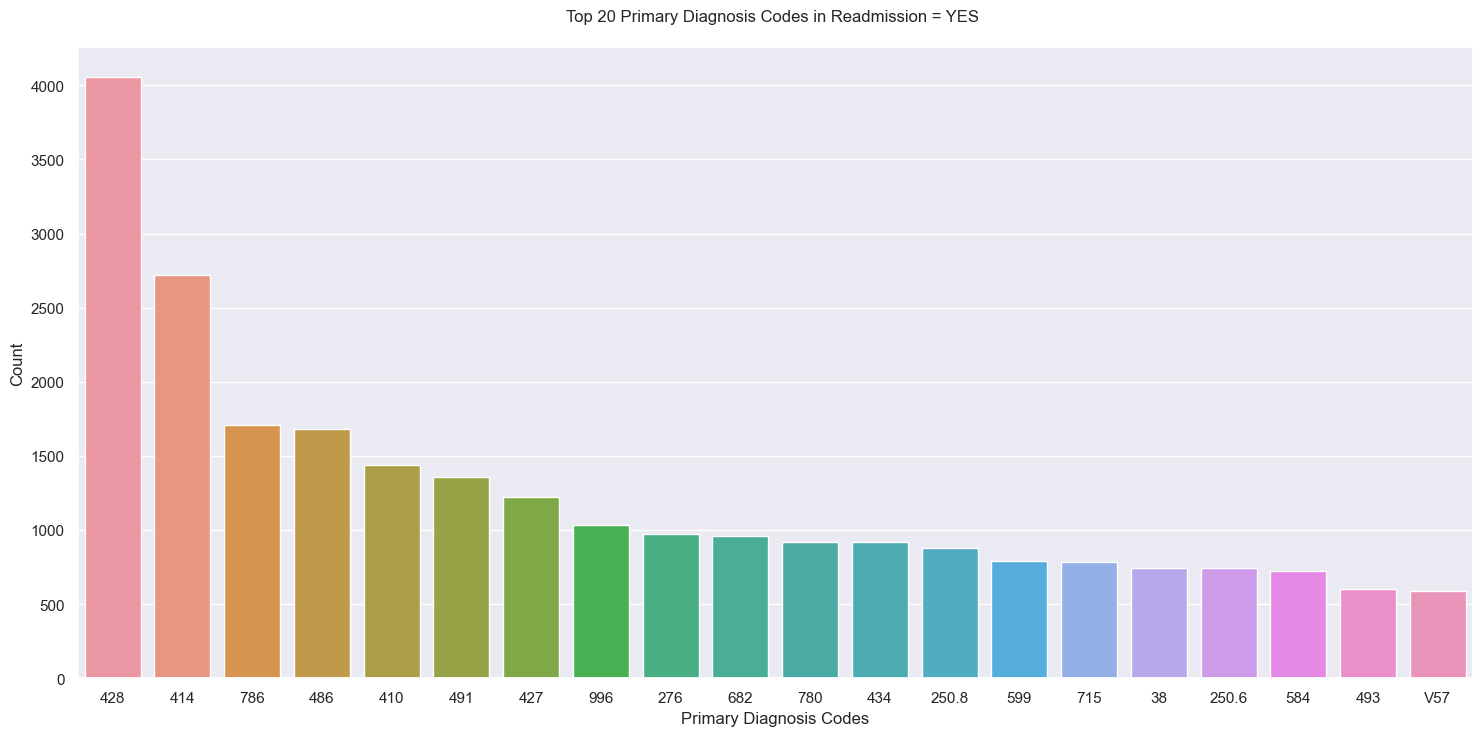

In [54]:
ax = sns.barplot(x=df[df['label'] == 'Si']['diag_1'].value_counts().index[:20],
                 y=df[df['label'] == 'Si']['diag_1'].value_counts()[:20])
plt.xlabel('Primary Diagnosis Codes', size = 12)
plt.ylabel('Count', size = 12)
plt.title('Top 20 Primary Diagnosis Codes in Readmission = YES \n', size = 12)
plt.show()

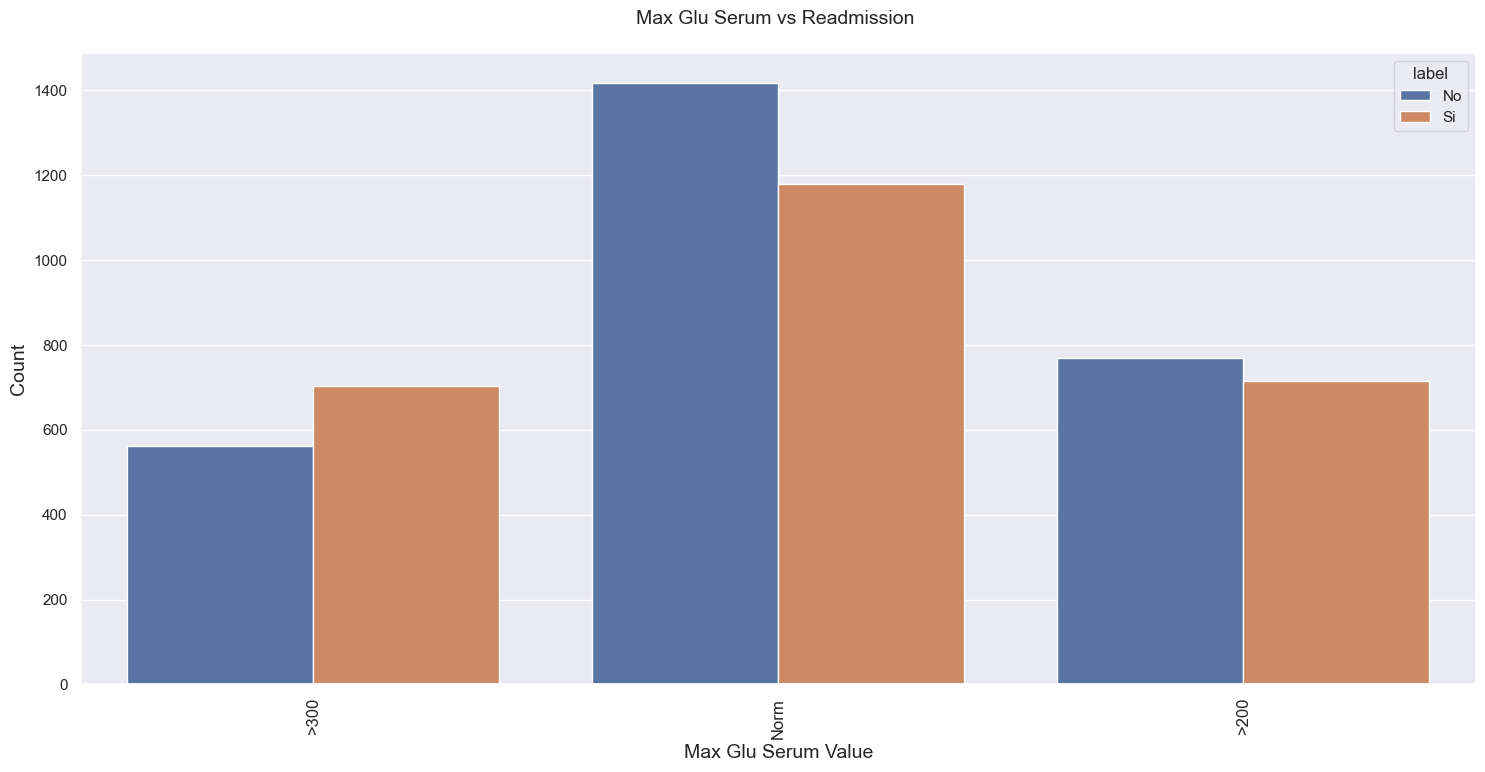

In [56]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='max_glu_serum',  hue= 'label', data= df[df['max_glu_serum']!='None'])
plt.xlabel('Max Glu Serum Value', size = 14)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 14)
plt.title('Max Glu Serum vs Readmission \n', size = 14)
plt.show()

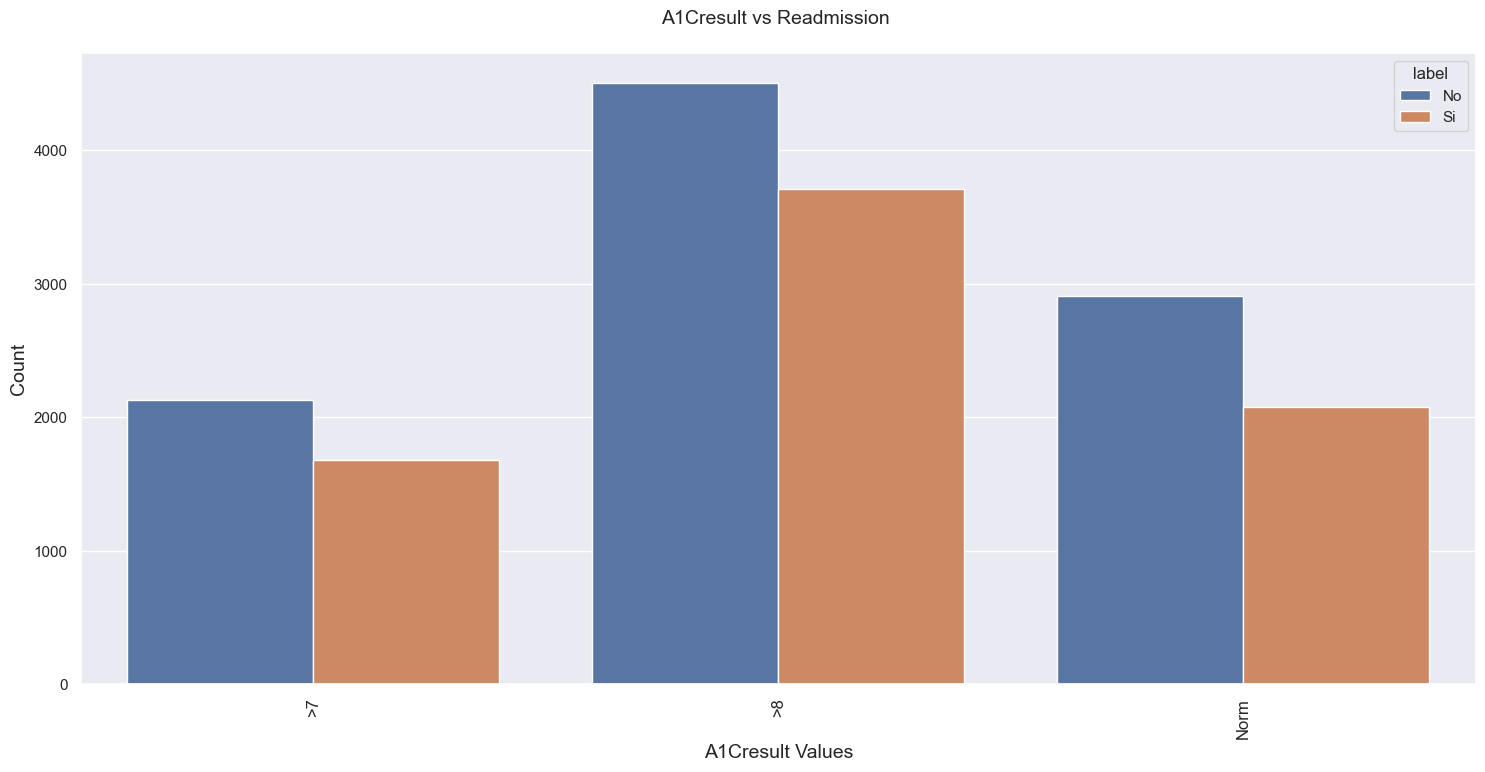

In [57]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='A1Cresult', hue = 'label', data=df[df['A1Cresult']!='None'])
plt.xlabel('A1Cresult Values', size = 14)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 14)
plt.title('A1Cresult vs Readmission \n', size = 14)
plt.show()

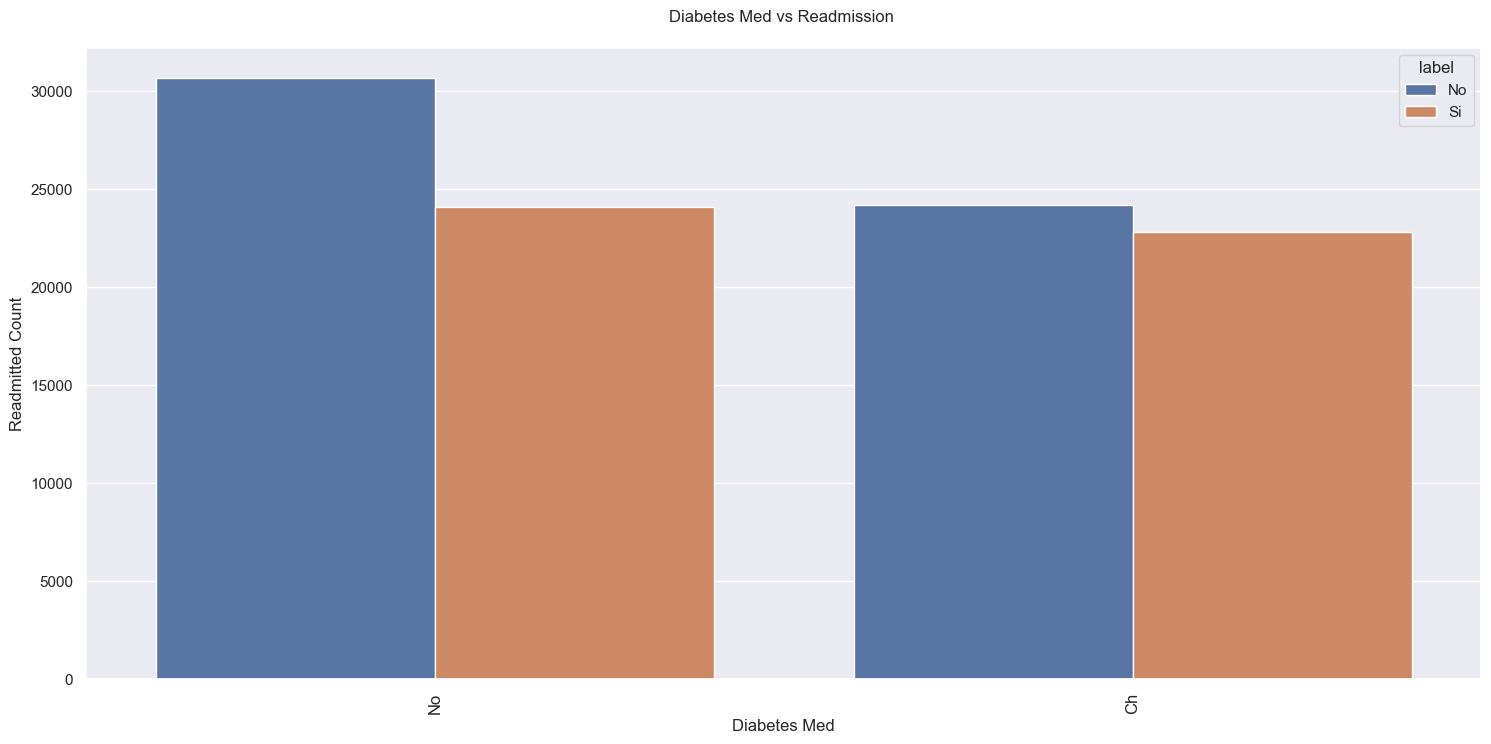

In [58]:
ax = sns.countplot(x='change',  hue= 'label',  data= df)
plt.xlabel('Diabetes Med', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Diabetes Med vs Readmission \n', size = 12)
plt.show()

In [ ]:
print(np.unique(df['age']))

replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

df['age'] = df['age'].apply(lambda x : replaceDict[x])
print(df['age'].head())